# COMP90084 Workshop Week 9 - QAOA
In this Jupyter Notebook, we will solve combinatorial optimization problems with the Quantum Approximate Optimization Algorithm (QAOA). We will code the QAOA algorithm with `Qiskit` as well as `Pennylane`.
## Combinatorial Optimization Problem
Combinatorial optimization problems involve finding an optimal object out of a finite set of objects. We would focus on problems that involve finding "optimal" bitstrings composed of 0's and 1's among a finite set of bitstrings. One such problem corresponding to a graph is the Max-Cut problem.
## Max-Cut Problem
The aim of MaxCut is to maximize the number of edges (yellow lines) in a graph that are “cut” by a given partition of the vertices (blue circles) into two sets (see figure below).
![](https://pennylane.ai/qml/_images/qaoa_maxcut_partition.png)



Consider a graph with $m$ edges and $n$ vertices. We seek the partition
$z$ of the vertices into two sets $A$ and $B$ which maximizes

$$C(z) = \sum_{\alpha=1}^{m}C_\alpha(z),$$

where $C$ counts the number of edges cut. $C_\alpha(z)=1$ if $z$ places
one vertex from the $\alpha^\text{th}$ edge in set $A$ and the other in
set $B$, and $C_\alpha(z)=0$ otherwise. Finding a cut which yields the
maximum possible value of $C$ is an NP-complete problem, so our best
hope for a polynomial-time algorithm lies in an approximate
optimization. In the case of MaxCut, this means finding a partition $z$
which yields a value for $C(z)$ that is close to the maximum possible
value.

We can represent the assignment of vertices to set $A$ or $B$ using a
bitstring, $z=z_1...z_n$ where $z_i=0$ if the $i^\text{th}$ vertex is in
$A$ and $z_i = 1$ if it is in $B$. For instance, in the situation
depicted in the figure above the bitstring representation is
$z=0101\text{,}$ indicating that the $0^{\text{th}}$ and $2^{\text{nd}}$
vertices are in $A$ while the $1^{\text{st}}$ and $3^{\text{rd}}$ are in
$B$. This assignment yields a value for the objective function (the
number of yellow lines cut) $C=4$, which turns out to be the maximum
cut. 

## QAOA


The quantum approximate optimization algorithm (QAOA) is a general
technique that can be used to find approximate solutions to
combinatorial optimization problems, in particular problems that can be
cast as searching for an optimal bitstring. QAOA consists of the
following steps:

1.  Define a *cost Hamiltonian* $H_C$ such that its ground state encodes
    the solution to the optimization problem. For the cost Hamiltonian of other NP problems, see [Ising formulations of many NP problems](https://arxiv.org/abs/1302.5843).
2.  Define a *mixer Hamiltonian* $H_M$.
3.  Construct the circuits $e^{-i \gamma H_C}$ and $e^{-i\alpha H_M}$.
    We call these the *cost* and *mixer layers*, respectively.
4.  Choose a parameter $n\geq 1$ and build the circuit

    $$U(\boldsymbol\gamma, \ \boldsymbol\alpha) \ = \ e^{-i \alpha_n H_M}
    e^{-i \gamma_n H_C} \ ... \ e^{-i \alpha_1 H_M} e^{-i \gamma_1 H_C},$$

    consisting of repeated application of the cost and mixer layers.

5.  Prepare an initial state, apply
    $U(\boldsymbol\gamma,\boldsymbol\alpha)$, and use classical
    techniques to optimize the parameters.
6.  After the circuit has been optimized, measurements of the output
    state reveal approximate solutions to the optimization problem.

In summary, the starting point of QAOA is the specification of cost and
mixer Hamiltonians. We then use time evolution and layering to create a
variational circuit and optimize its parameters. The algorithm concludes
by sampling from the circuit to get an approximate solution to the
optimization problem.

## A circuit for QAOA


This section describes implementing a circuit for QAOA using basic
unitary gates to find approximate solutions to the MaxCut problem.
Firstly, denoting the partitions using computational basis states
$|z\rangle$, we can represent the terms in the objective function as
operators acting on these states

$$C_\alpha = \frac{1}{2}\left(1-\sigma_{z}^j\sigma_{z}^k\right),$$

where the $\alpha\text{th}$ edge is between vertices $(j,k)$. $C_\alpha$
has eigenvalue 1 if and only if the $j\text{th}$ and $k\text{th}$ qubits
have different z-axis measurement values, representing separate
partitions. The objective function $C$ can be considered a diagonal
operator with integer eigenvalues.

QAOA starts with a uniform superposition over the $n$ bitstring basis
states,

$$|+_{n}\rangle = \frac{1}{\sqrt{2^n}}\sum_{z\in \{0,1\}^n} |z\rangle.$$

We aim to explore the space of bitstring states for a superposition
which is likely to yield a large value for the $C$ operator upon
performing a measurement in the computational basis. Using the $2p$
angle parameters $\boldsymbol{\gamma} = \gamma_1\gamma_2...\gamma_p$,
$\boldsymbol{\beta} = \beta_1\beta_2...\beta_p$ we perform a sequence of
operations on our initial state:

$$|\boldsymbol{\gamma},\boldsymbol{\beta}\rangle = U_{B_p}U_{C_p}U_{B_{p-1}}U_{C_{p-1}}...U_{B_1}U_{C_1}|+_n\rangle$$

where the operators have the explicit forms

$$\begin{aligned}
U_{B_l} &= e^{-i\beta_lB} = \prod_{j=1}^n e^{-i\beta_l\sigma_x^j}, \\
U_{C_l} &= e^{-i\gamma_lC} = \prod_{\text{edge (j,k)}} e^{-i\gamma_l(1-\sigma_z^j\sigma_z^k)/2}.
\end{aligned}$$

In other words, we make $p$ layers of parametrized $U_bU_C$ gates. These
can be implemented on a quantum circuit using the gates depicted below,
up to an irrelevant constant that gets absorbed into the parameters.

![](https://pennylane.ai/qml/_images/qaoa_operators.png)


Let $\langle \boldsymbol{\gamma},
\boldsymbol{\beta} | C | \boldsymbol{\gamma},\boldsymbol{\beta} \rangle$
be the expectation of the objective operator. In the next section, we
will use PennyLane to perform classical optimization over the circuit
parameters $(\boldsymbol{\gamma}, \boldsymbol{\beta})$. This will
specify a state $|\boldsymbol{\gamma},\boldsymbol{\beta}\rangle$ which
is likely to yield an approximately optimal partition $|z\rangle$ upon
performing a measurement in the computational basis. In the case of the
graph shown above, we want to measure either 0101 or 1010 from our state
since these correspond to the optimal partitions.

![](https://pennylane.ai/qml/_images/qaoa_optimal_state.png)

Qualitatively, QAOA tries to evolve the initial state into the plane of
the $|0101\rangle$, $|1010\rangle$ basis states (see figure above).

## QAOA in Pennylane

In [1]:
# imports and setup
import pennylane as qml
from pennylane import numpy as np

np.random.seed(42)

In [2]:
# Operators
# U_B acts on individual qubits
# U_C acts on qubits whose corresponding vertices are joined by an edge in the graph
n_wires = 4
graph = [(0, 1), (0, 3), (1, 2), (2, 3)]

# unitary operator U_B with parameter beta
def U_B(beta):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)


# unitary operator U_C with parameter gamma
def U_C(gamma):
    for edge in graph:
        wire1 = edge[0]
        wire2 = edge[1]
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(gamma, wires=wire2)
        qml.CNOT(wires=[wire1, wire2])

In [3]:
def bitstring_to_int(bit_string_sample):
    bit_string = "".join(str(bs) for bs in bit_string_sample)
    return int(bit_string, base=2)

In [4]:
# create a quantum device
dev = qml.device("default.qubit", wires=n_wires, shots=1)
# define the circuit
@qml.qnode(dev)
def circuit(gammas, betas, edge=None, n_layers=1):
    # apply Hadamards to get the n qubit |+> state
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    # p instances of unitary operators
    for i in range(n_layers):
        U_C(gammas[i])
        U_B(betas[i])
    if edge is None:
        # measurement phase
        return qml.sample()
    # during the optimization phase we are evaluating a term
    # in the objective using expval
    H = qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1])
    return qml.expval(H)

In [5]:
# optimization, with gradient descent based optimizer
# just like training a neural network
def qaoa_maxcut(n_layers=1):
    print("\np={:d}".format(n_layers))

    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(2, n_layers, requires_grad=True)

    # minimize the negative of the objective function
    def objective(params):
        gammas = params[0]
        betas = params[1]
        neg_obj = 0
        for edge in graph:
            # objective for the MaxCut problem
            neg_obj -= 0.5 * (1 - circuit(gammas, betas, edge=edge, n_layers=n_layers))
        return neg_obj

    # initialize optimizer: Adagrad works well empirically
    opt = qml.AdagradOptimizer(stepsize=0.5)

    # optimize parameters in objective
    params = init_params
    steps = 30
    for i in range(steps):
        params = opt.step(objective, params)
        if (i + 1) % 5 == 0:
            print("Objective after step {:5d}: {: .7f}".format(i + 1, -objective(params)))

    # sample measured bitstrings 100 times
    bit_strings = []
    n_samples = 100
    for i in range(0, n_samples):
        bit_strings.append(bitstring_to_int(circuit(params[0], params[1], edge=None, n_layers=n_layers)))

    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)
    print("Optimized (gamma, beta) vectors:\n{}".format(params[:, :n_layers]))
    print("Most frequently sampled bit string is: {:04b}".format(most_freq_bit_string))

    return -objective(params), bit_strings


# perform qaoa on our graph with p=1,2 and
# keep the bitstring sample lists
bitstrings1 = qaoa_maxcut(n_layers=1)[1]
bitstrings2 = qaoa_maxcut(n_layers=2)[1]


p=1
Objective after step     5:  4.0000000
Objective after step    10:  3.0000000
Objective after step    15:  4.0000000
Objective after step    20:  3.0000000
Objective after step    25:  3.0000000
Objective after step    30:  3.0000000
Optimized (gamma, beta) vectors:
[[-0.63789432]
 [ 0.42900392]]
Most frequently sampled bit string is: 1010

p=2
Objective after step     5:  2.0000000
Objective after step    10:  4.0000000
Objective after step    15:  3.0000000
Objective after step    20:  4.0000000
Objective after step    25:  4.0000000
Objective after step    30:  4.0000000
Optimized (gamma, beta) vectors:
[[-1.63774005  0.95207792]
 [-0.36133511 -0.85343068]]
Most frequently sampled bit string is: 0101


In the case where we set `n_layers=2`, we recover the optimal objective
function $C=4$

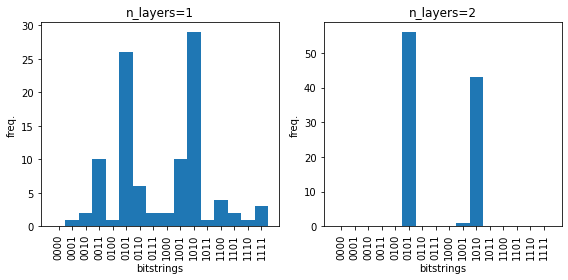

In [6]:
# plot the results
import matplotlib.pyplot as plt

xticks = range(0, 16)
xtick_labels = list(map(lambda x: format(x, "04b"), xticks))
bins = np.arange(0, 17) - 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("n_layers=1")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings1, bins=bins)
plt.subplot(1, 2, 2)
plt.title("n_layers=2")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings2, bins=bins)
plt.tight_layout()
plt.show()

## QAOA with Qiskit
Since Qiskit already has an implementation of QAOA, we'll just use it to solve the graph partition problem.

In [7]:
import matplotlib.axes as axes
import numpy as np
import networkx as nx
import operator
from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from collections import OrderedDict

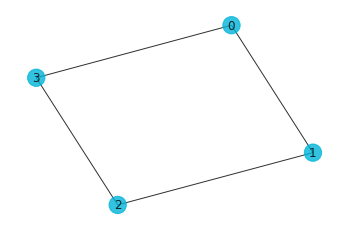

In [8]:
# construct the graph
n = 4
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = graph
G.add_edges_from(elist)
colors = ["#00b4d9" for node in G.nodes()]
pos = nx.spring_layout(G,seed=42)
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=False)
    nx.draw_networkx(G, node_color=colors, node_size=300, alpha=0.8, pos=pos, ax=default_axes)
    #edge_labels = nx.get_edge_attributes(G, "weight")
    #nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    plt.show()
draw_graph(G, colors, pos)

In [9]:
# Computing the weight matrix from the graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = 1
print(w)

[[0. 1. 0. 1.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [1. 0. 1. 0.]]


case = [0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0] cost = 2.0
case = [0, 1, 0, 0] cost = 2.0
case = [1, 1, 0, 0] cost = 2.0
case = [0, 0, 1, 0] cost = 2.0
case = [1, 0, 1, 0] cost = 4.0
case = [0, 1, 1, 0] cost = 2.0
case = [1, 1, 1, 0] cost = 2.0
case = [0, 0, 0, 1] cost = 2.0
case = [1, 0, 0, 1] cost = 2.0
case = [0, 1, 0, 1] cost = 4.0
case = [1, 1, 0, 1] cost = 2.0
case = [0, 0, 1, 1] cost = 2.0
case = [1, 0, 1, 1] cost = 2.0
case = [0, 1, 1, 1] cost = 2.0
case = [1, 1, 1, 1] cost = 0.0
All Solutions:
 {'[1, 0, 1, 0]': 4.0, '[0, 1, 0, 1]': 4.0, '[1, 0, 0, 0]': 2.0, '[0, 1, 0, 0]': 2.0, '[1, 1, 0, 0]': 2.0, '[0, 0, 1, 0]': 2.0, '[0, 1, 1, 0]': 2.0, '[1, 1, 1, 0]': 2.0, '[0, 0, 0, 1]': 2.0, '[1, 0, 0, 1]': 2.0, '[1, 1, 0, 1]': 2.0, '[0, 0, 1, 1]': 2.0, '[1, 0, 1, 1]': 2.0, '[0, 1, 1, 1]': 2.0, '[0, 0, 0, 0]': 0.0, '[1, 1, 1, 1]': 0.0}

Best solution = [1, 0, 1, 0] cost = 4.0


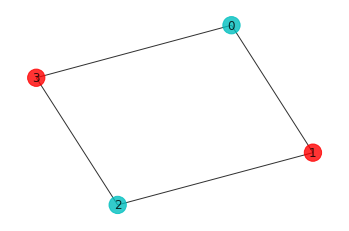

In [10]:
# use the brute force method
best_cost_brute = 0
cases = {}
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print("case = " + str(x) + " cost = " + str(cost))
    cases[str(x)] = cost
cases = dict(sorted(cases.items(), key=operator.itemgetter(1),reverse=True))
print("All Solutions:\n", cases)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))
colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

In [11]:
# use the Maxcut class in Qiskit
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.export_as_lp_string())
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Max-cut

Maximize
 obj: 2 x_0 + 2 x_1 + 2 x_2 + 2 x_3 + [ - 4 x_0*x_1 - 4 x_0*x_3 - 4 x_1*x_2
      - 4 x_2*x_3 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1

Binaries
 x_0 x_1 x_2 x_3
End

Offset: -2.0
Ising Hamiltonian:
0.5 * IIZZ
+ 0.5 * IZZI
+ 0.5 * ZIIZ
+ 0.5 * ZZII


In [12]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result)

fval=4.0, x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, status=SUCCESS


energy: -2.0
max-cut objective: -4.0
solution: [1 0 1 0]
solution objective: 4.0


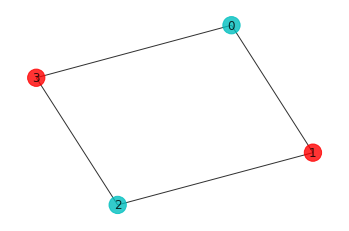

In [13]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
# with the exact classical eigensolver
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

energy: -1.9995900934685757
time: 1.3063788414001465
max-cut objective: -3.9995900934685755
solution: [0. 1. 0. 1.]
solution objective: 4.0


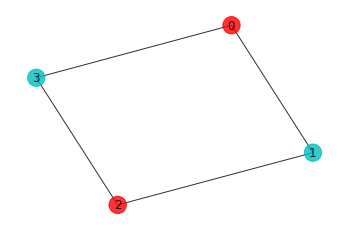

In [14]:
# Calculate the eigensystems with VQE
algorithm_globals.random_seed = 123
seed = 10598
backend = Aer.get_backend("aer_simulator_statevector")
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

fval=4.0, x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, status=SUCCESS


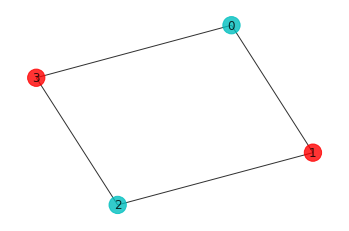

In [15]:
# create minimum eigen optimizer based on VQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result)

colors = ["r" if result.x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)